In [45]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from utils.mylib import *
from d2l import torch as d2l

In [46]:
init_Seed()

No GPU!


In [47]:
class MLDataset(Dataset):
    """ Dataset for loading and preprocessing the MoviesLen dataset. """
    def __init__(self, path, mode='train', target_only=False):
        super().__init__()
        self.mode = mode

        # Read data into numpy arrays
        data = np.loadtxt(path, dtype='long')

        # Convert data into PyTorch tensors
        self.data = torch.LongTensor(data[:, :2])
        self.target = torch.FloatTensor(data[:, 2])
 

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of MoviesLen Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
    

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]
    

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [48]:
class MF(nn.Module):
    def __init__(self, n_users=1000, m_items=2000, n_factors=20):
        super(MF, self).__init__()

        self.U = torch.nn.Embedding(n_users, n_factors)
        self.V = torch.nn.Embedding(m_items, n_factors)

        self.U.weight.data.uniform_(-0.005, 0.005)
        self.V.weight.data.uniform_(-0.005, 0.005)
        
        self.criterion = nn.MSELoss(reduction='sum')
    
    def forward(self, user, item):
        # return (self.user_factors(user) * self.item_factors(item)).sum(1)
        return torch.einsum('ij, ij -> i', [self.U(user), self.V(item)])
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [49]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = MLDataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# **Train/Dev/Test**

In [50]:
# U = torch.rand(size=(1005, 20), requires_grad=True)
# V = torch.rand(size=(2005, 20), requires_grad=True)
# with torch.no_grad():
#     U /= 100
#     V /= 100

## **Training**

In [51]:
# def model(X):
#     return torch.einsum('ij, ij -> i', [U[X[:, 0]], V[X[:, 1]]])

# def squared_loss(y_hat, y):  #@save
#     """Squared loss."""
#     return (y_hat - y.reshape(y_hat.shape))**2 / 2

# def objective(X, y):
#     return squared_loss(model(X), y).sum() + (U[X[:, 0]].norm() ** 2 + V[X[:, 1]].norm() ** 2) * 0.01

# def sgd(params, lr, batch_size):  #@save
#     """Minibatch stochastic gradient descent."""
#     with torch.no_grad():
#         for param in params:
#             param -= lr * param.grad
#             param.grad.zero_()

In [52]:
def train(tr_set, dv_set, model, config):
    n_epochs = config['n_epochs']  # Maximum number of epochs
    batch_size = config['batch_size']

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


    min_mse = 1000.
    loss_record = {'train': [], 'dev': []} 
    early_stop_cnt = 0
    epoch = 0

    while epoch < n_epochs:
        model.train()
        for X, y in tr_set:
            optimizer.zero_grad()    
            X, y = X.to(device), y.to(device)
            y_hat = model(X[:, 0], X[:, 1])
            mse_loss = model.cal_loss(y_hat, y)
            mse_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item() / batch_size)
        
        epoch += 1
        
        print("train_loss: {:.4f}".format(np.mean(loss_record['train'][-100:])))

        dev_mse = dev(dv_set, model, device) / batch_size
        if dev_mse < min_mse:
            min_mse = dev_mse
            early_stop_cnt = 0
            print("Saving model (epoch = {:4d}  loss = {:.4f} )".format(epoch, dev_mse))
            torch.save(model.state_dict(), config['save_path'])
        else:
            early_stop_cnt += 1
        
        
        loss_record['dev'].append(dev_mse)

        if early_stop_cnt > config['early_stop']:
            break

    print("Finish training after {} epochs".format(epoch))
    return min_mse, loss_record

In [53]:
# def train2():
#     n_epochs = config['n_epochs']  # Maximum number of epochs

#     loss = squared_loss
        
#     # Setup optimizer
#     optimizer = getattr(torch.optim, config['optimizer'])(
#         [U, V], **config['optim_hparas'])

#     min_mse = 1000.
#     loss_record = {'train': [], 'dev': []} 
#     early_stop_cnt = 0
#     epoch = 0

#     while epoch < n_epochs:

#         for X, y in tr_set:
#             optimizer.zero_grad()
#             X, y = X.to(device), y.to(device)
#             y_hat = model(X)
#             mse_loss = loss(y_hat, y)
#             mse_loss.sum().backward()
#             optimizer.step()
            
#         epoch += 1
        
#         with torch.no_grad():
#             train_l = loss(model(X), y)
#             print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

## **Validation**

In [54]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for X, y in dv_set:                         # iterate through the dataloader
        X, y = X.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(X[:, 0], X[:, 1])                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(X)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [55]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [56]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 500,              # maximum number of epochs
    'batch_size': 256,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.005,                # learning rate
        'weight_decay': 0.1
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 60,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [57]:
tr_set = prep_dataloader('../data/ML100K/ML100K_copy1_train.txt', 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader('../data/ML100K/ML100K_copy1_test.txt', 'dev', config['batch_size'], target_only=target_only)
# tt_set = prep_dataloader("data/ML100K/ML100K_copy1_test.txt", 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of MoviesLen Dataset (60000 samples found, each dim = 2)
Finished reading the dev set of MoviesLen Dataset (20000 samples found, each dim = 2)


In [58]:
model = MF().to(device) 

# **Start Training!**

In [59]:
# model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

In [60]:
%%time
model_loss, model_loss_record = train(tr_set, dv_set, model, config)

train_loss: 2.1836
Saving model (epoch =    1  loss = 1.4114 )
train_loss: 0.9974
Saving model (epoch =    2  loss = 1.0071 )
train_loss: 0.9138
Saving model (epoch =    3  loss = 0.9724 )
train_loss: 0.8800
Saving model (epoch =    4  loss = 0.9516 )
train_loss: 0.8343
Saving model (epoch =    5  loss = 0.9502 )
train_loss: 0.8069
Saving model (epoch =    6  loss = 0.9400 )
train_loss: 0.7724
train_loss: 0.7307
Saving model (epoch =    8  loss = 0.9397 )
train_loss: 0.6982
train_loss: 0.6652
train_loss: 0.6197
train_loss: 0.5875
train_loss: 0.5374
train_loss: 0.5089
train_loss: 0.4730
train_loss: 0.4412
train_loss: 0.4216
train_loss: 0.3983
train_loss: 0.3846
train_loss: 0.3649
train_loss: 0.3600
train_loss: 0.3493
train_loss: 0.3368
train_loss: 0.3317
train_loss: 0.3247
train_loss: 0.3198
train_loss: 0.3136
train_loss: 0.3080
train_loss: 0.3075
train_loss: 0.3012
train_loss: 0.3011
train_loss: 0.2947
train_loss: 0.2872
train_loss: 0.2885
train_loss: 0.2850
train_loss: 0.2796
train_lo

In [61]:
# train2()

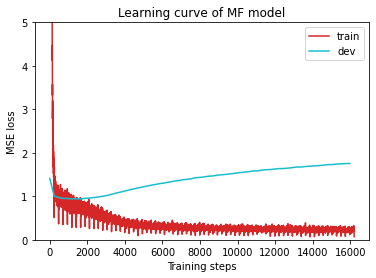

In [62]:
plot_learning_curve(model_loss_record, title='MF model')

In [63]:
np.sqrt(model_loss)

0.9694020145238021

In [64]:
np.sqrt(model_loss_record['dev'][-1])

1.3249143135776822

In [65]:
# del model
# model = MF().to(device)
# ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
# model.load_state_dict(ckpt)
# # plot_pred(dv_set, model, device)  # Show prediction on the validation set
# dev(dv_set, model, device)

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [66]:
# def save_pred(preds, file):
#     ''' Save predictions to specified file '''
#     print('Saving results to {}'.format(file))
#     with open(file, 'w') as fp:
#         writer = csv.writer(fp)
#         writer.writerow(['id', 'tested_positive'])
#         for i, p in enumerate(preds):
#             writer.writerow([i, p])

# preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
# save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
